In [1]:
import pandas as pd ##Data handeler
import numpy as np ##Maths functions
import seaborn as sns ##Graphing
import matplotlib ##Graphing
import matplotlib.pyplot as plt


from scipy.stats import skew
from scipy.stats.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, LassoLarsCV, ElasticNet
from sklearn.model_selection import cross_val_score

#Not being used in this version of the regression algorithm
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.ensemble import VotingClassifier, BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn import tree


##ignore depreciation error - specific module not being used##

C:\Users\rpast\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Import Data Set

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Select Columns (remove sale price)

In [3]:
data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']))

# Take Log of Sale Price

In [4]:
train["SalePrice"] = np.log1p(train["SalePrice"])
#This is currently commented out until it can be unloged


# Create Variable Containing Columns

In [5]:
columns = data.dtypes[data.dtypes != "object"].index

# Removes feilds with no data

In [6]:
skewed = train[columns].apply(lambda y: skew(y.dropna()))

In [7]:
skewed = skewed.index
data[skewed] = np.log1p(data[skewed])
#Ignore this error - this will be fixed in a future version

C:\Users\rpast\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  


# Fill Blank Fields with Mean

In [8]:
data = (pd.get_dummies(data)).fillna(data.mean())

# Put Sampled data into appropriate varaibles

In [9]:
X_train = data[:train.shape[0]]
X_test = data[train.shape[0]:]
y = train["SalePrice"]
print(y)

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
5       11.870607
6       12.634606
7       12.206078
8       11.774528
9       11.678448
10      11.771444
11      12.751303
12      11.877576
13      12.540761
14      11.964007
15      11.790565
16      11.911708
17      11.407576
18      11.976666
19      11.842236
20      12.692506
21      11.845110
22      12.345839
23      11.774528
24      11.944714
25      12.454108
26      11.811555
27      12.631344
28      12.242891
29      11.134604
          ...    
1430    12.165985
1431    11.875838
1432    11.074436
1433    12.136192
1434    11.982935
1435    12.066816
1436    11.699413
1437    12.885673
1438    11.916395
1439    12.190964
1440    12.160034
1441    11.913720
1442    12.644331
1443    11.703554
1444    12.098493
1445    11.767575
1446    11.969724
1447    12.388398
1448    11.626263
1449    11.429555
1450    11.820418
1451    12.567555
1452    11.884496
1453    11.344519
1454    12

# Root mean square function


In [10]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

# Ridge reggression?

In [11]:
model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0,0.5,'rmse')

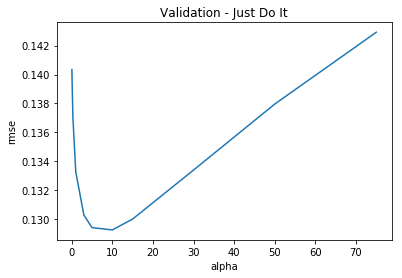

In [12]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

#rmse --> Root mean squared error

In [13]:
cv_ridge.min()

0.12926246566508087

# Lasso model?

In [14]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [15]:
rmse_cv(model_lasso).mean()

0.12449130123052536

In [16]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 110 variables and eliminated the other 178 variables


In [17]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5,1,'Coefficients in the Lasso Model')

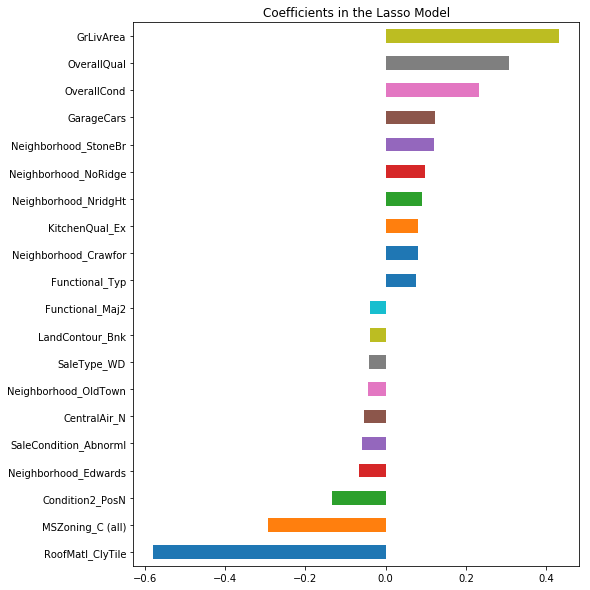

In [18]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

# Linear Regression Algorithm

In [19]:
linearRegression = LinearRegression()
linearRegression.fit(X_train, y)
linearRegression.score(X_train, y)


#Would be good to graph this data

0.9464089328204002

In [21]:
prediction_linearRegression = linearRegression.predict(X_test)
print(prediction_linearRegression)


[11.69598823 12.02564639 12.15318491 ... 12.09839049 11.7132942
 12.28544294]


In [32]:

lasso_preds = np.expm1(model_lasso.predict(X_test))
predictions = pd.DataFrame({"lasso":lasso_preds})
print(predictions)


              lasso
0     117747.647282
1     157402.048523
2     181689.519656
3     196401.369291
4     202555.271552
5     170257.199540
6     175710.459473
7     158365.425159
8     199005.125722
9     120063.580952
10    184183.097714
11     98503.215086
12     95536.820802
13    144678.737269
14    107637.806417
15    353470.880435
16    242413.670269
17    300022.390811
18    302874.282655
19    473529.099756
20    327178.655296
21    214526.942948
22    183480.368996
23    161021.112997
24    196842.612361
25    197483.613404
26    339834.889623
27    235709.822646
28    192734.943213
29    250098.075565
...             ...
1429   82231.792220
1430  137629.017495
1431   40407.213199
1432   70503.869718
1433   55062.504142
1434  336464.667900
1435  270597.318874
1436  221245.831033
1437  152328.619388
1438  211621.674637
1439  157047.771335
1440  223078.832834
1441  188614.880868
1442  319588.675371
1443  335350.411368
1444   75642.177620
1445  187617.266650
1446  117075.217171


# Create Submission File 

In [31]:
submission = pd.DataFrame({'ID': test.Id, 'SalePrice': preds})
submission.to_csv('submission.csv', index=False)
